# CNNs Overview



Vamos a usar el DS MNIST.

Como primer paso, convertiremos los pixeles de cada imagen a un tensor estabilizado entre 0 y 1 para poder usarse.

In [1]:
# Arranque: imports, dataset y primer batch (MNIST)
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Aqui convertimos las imagenes a tensores
# Es decir, el valor de los pixeles pasa a estar entre 0 y 1
# y el shape de las imagenes pasa a ser (C,H,W) (Canales, Alto, Ancho)

transform = transforms.ToTensor()  # [0,1], shape (C,H,W)

train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(train, batch_size=4, shuffle=True)

# Cogemos un batch de 4 imagenes
images, labels = next(iter(loader))

# Imprimimos el shape de las imagenes y las etiquetas
print("images.shape:", images.shape)   # esperado: ([4, 1, 28, 28])

# Imprimimos las etiquetas
print("labels:", labels.tolist())

# Comprobamos que el shape de las imagenes es el esperado
assert images.ndim == 4 and images.shape[1] == 1 and images.shape[2] == 28 and images.shape[3] == 28


cuda
images.shape: torch.Size([4, 1, 28, 28])
labels: [6, 8, 8, 7]


Vamos a dar un vistazo para entender mejor

In [2]:
images_cuda = images.to(device)
one_image = images_cuda[0]

C, H, W = one_image.shape

#Podemos observar como solo hay un unico canal, que es el negro y blanco.
#Si fuera algo a color, habria 3 canales (R, G, B)
#Si ademas tuviera transparencia, habria 4 canales (R, G, B, A)


print(f"Canales: {C}, Alto: {H}, Ancho: {W}")

print(f"Rango de píxeles: {one_image.min():.3f} a {one_image.max():.3f}")



Canales: 1, Alto: 28, Ancho: 28
Rango de píxeles: 0.000 a 1.000


### Capa de Convolución

#### Padding, Stride y Kernel

EL padding permite que los kernel tengan en cuenta más veces los pixeles de los bordes, al añadir un padding de 0s alrededor, el kernel tiene espacio para pasar mas veces por los pixeles de los bordes, un padding de 1 no reduce el tamaño de la imagen por ese motivo.

VALID PADDING = 0 // No hay marco, la imagen se reduce.

SAME PADDING = 1 // Hay marco, la imagen no se reduec.

In [16]:
#Declaramos la capa de convolución

# in_channels = 1, porque es una imagen en blanco y negro
# out_channels = 8, porque queremos 8 features (8 filtros)
# kernel_size = 3, porque queremos un kernel de 3x3 px
# padding = 1, porque queremos que la imagen siga teniendo el mismo tamaño
# stride = 1, porque queremos que el kernel se desplace 1 px por vez

conv = nn.Conv2d(in_channels=1, stride=1, out_channels=8, kernel_size=3, padding=1)
conv.to(device)

import matplotlib.pyplot as plt


#Declaramos la capa de pooling
pool = nn.MaxPool2d(2)
#Pasamos las imagenes al dispositivo
x = images_cuda  # (B, 1, 28, 28)


x1 = F.relu(conv(x))
print("Después de Conv+ReLU:", x1.shape)
x2 = pool(x1)
print("Después de MaxPool:", x2.shape)

assert x2.shape == (4, 8, 14, 14)

#Es decir, 4 imagenes, 8 features filtros, y 14x14 px tras aplicar el pooling


Después de Conv+ReLU: torch.Size([4, 8, 28, 28])
Después de MaxPool: torch.Size([4, 8, 14, 14])


Vamos a visualizar como cada uno de los filtros (out_channels) modifica la imagen y como el pooling reduce las mismas

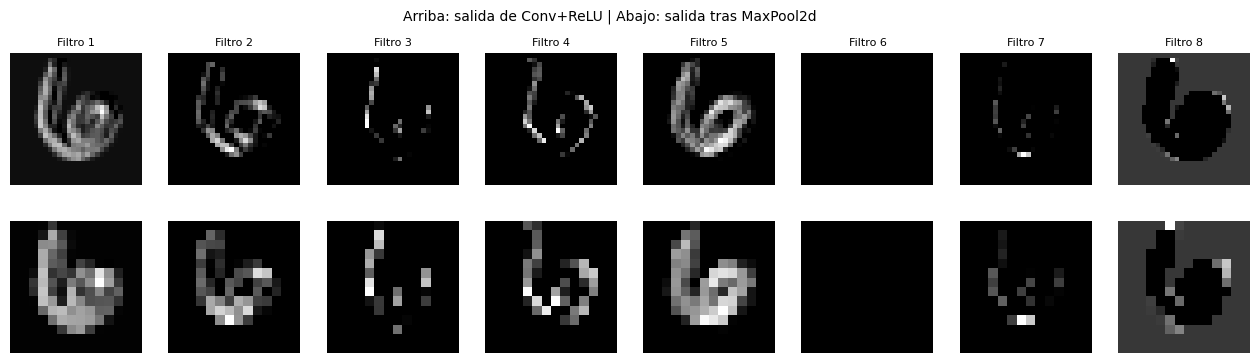

In [22]:
# ---------------------------------------------------
# Visualización de las activaciones de los filtros antes y despues del pooling
# ---------------------------------------------------

img_idx = 0  # primera imagen del batch

# Antes del pooling
acts_before = x1[img_idx].detach().cpu()  # (8, 28, 28)

# Después del pooling
acts_after = x2[img_idx].detach().cpu()    # (8, 14, 14)

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    # Arriba: antes del pooling
    axes[0, i].imshow(acts_before[i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Filtro {i+1}', fontsize=8)

    # Abajo: después del pooling
    axes[1, i].imshow(acts_after[i], cmap='gray')
    axes[1, i].axis('off')

plt.suptitle("Arriba: salida de Conv+ReLU | Abajo: salida tras MaxPool2d", fontsize=10)
plt.show()